In [1]:
import re
import os
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import nltk
import kagglehub
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
from collections import Counter

# 1. Dataset Preparation

In [2]:
path = kagglehub.dataset_download(
    "suchintikasarkar/sentiment-analysis-for-mental-health"
)
print("Path to dataset files:", path)

Path to dataset files: /home/cici/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [3]:
df = pd.read_csv(path + "/Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df = df.dropna()

In [6]:
dups = df.duplicated(subset=["statement"]).sum()
print(f"Total duplicate statements in entire dataset: {dups}")

dups_per_status = (
    df[df.duplicated(subset=["statement"], keep=False)].groupby("status").size()
)
print("\nDuplicates found per status:")
print(dups_per_status)

df = df.drop_duplicates(subset=["statement"], keep="first").copy()

Total duplicate statements in entire dataset: 1608

Duplicates found per status:
status
Anxiety                 433
Bipolar                 552
Depression              601
Normal                  463
Personality disorder    362
Stress                  574
Suicidal                 26
dtype: int64


# 2. Dataset Analysis

## 2.1. Exploratory Data Analysis (EDA)

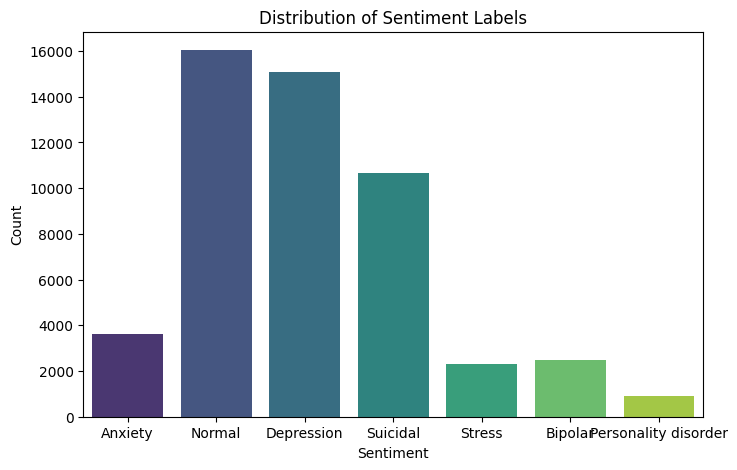

In [7]:
plt.figure(figsize=(8, 5))
sns.countplot(x="status", data=df, hue="status", palette="viridis", legend=False)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

In [8]:
drop = ["Anxiety", "Stress", "Bipolar", "Personality disorder"]

df = df[~df["status"].isin(drop)].copy()
df = df.reset_index(drop=True)

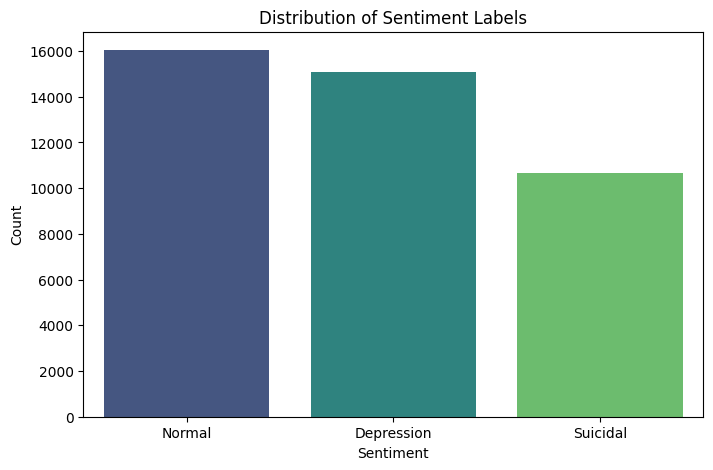

In [9]:
plt.figure(figsize=(8, 5))
sns.countplot(x="status", data=df, hue="status", palette="viridis", legend=False)
plt.title("Distribution of Sentiment Labels")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

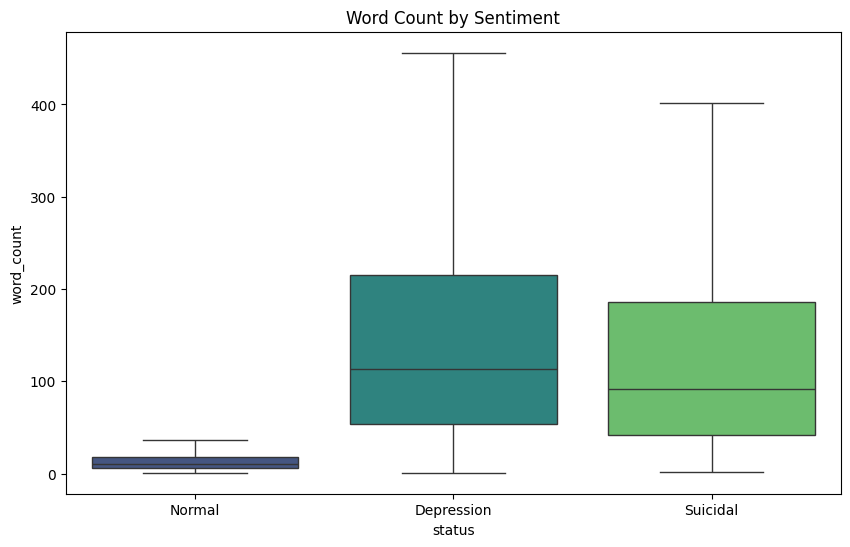

In [10]:
df["word_count"] = df["statement"].apply(lambda x: len(str(x).split()))

plt.figure(figsize=(10, 6))
sns.boxplot(
    x="status",
    y="word_count",
    data=df,
    hue="status",
    palette="viridis",
    legend=False,
    showfliers=False,
)
plt.title("Word Count by Sentiment")
plt.show()

## 2.2. Manual Analysis for Some Samples

# 3. Dataset Preprocessing

In [11]:
nltk.download("wordnet")
lemmatizer = WordNetLemmatizer()


def preprocess(text):
    text = text.encode("ascii", "ignore").decode()

    text = re.sub(r"https?:\/\/\S+|www\.\S+", "", text)  # Removes URL
    text = re.sub(r"@\w+", "", text)  # Removes "@Username"

    text = text.lower()  # Lowercase

    # \w+(?:'\w+)? -> Matches words and contractions (don't, i'm)
    # [^\w\s]+     -> Matches clusters of punctuation (??, ..., !!!)
    pattern = r"\w+(?:'\w+)?|[^\w\s]+"

    tokens = re.findall(pattern, text)

    clean_tokens = []
    for t in tokens:
        if re.match(r"\w+", t):
            clean_tokens.append(lemmatizer.lemmatize(t))
        else:
            clean_tokens.append(t)

    return " ".join(clean_tokens)


df["statement_processed"] = df["statement"].apply([preprocess])

[nltk_data] Downloading package wordnet to /home/cici/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [12]:
def filter_noise(df, text_col="statement_processed", label_col="status", threshold=0.9):
    unique_statuses = df[label_col].unique()
    status_word_ratios = {}
    all_vocab = set()

    for status in unique_statuses:
        subset = df[df[label_col] == status][text_col]
        total_docs = len(subset)

        if total_docs == 0:
            continue

        word_doc_counts = Counter()
        for text in subset:
            words = set(re.findall(r"\b\w+\b", str(text).lower()))
            word_doc_counts.update(words)
            all_vocab.update(words)

        status_word_ratios[status] = {
            word: count / total_docs for word, count in word_doc_counts.items()
        }

    common_words = []
    for word in all_vocab:
        is_noise = True
        for status in unique_statuses:
            if status_word_ratios[status].get(word, 0) < threshold:
                is_noise = False
                break

        if is_noise:
            common_words.append(word)

    return sorted(common_words)


global_noise = filter_noise(df, threshold=0.8)
print(global_noise)

[]


In [13]:
def top_words_per_class(
    df, text_col="statement_processed", label_col="status", top_k=20
):
    unique_statuses = df[label_col].unique()

    top_words_dict = {}

    for status in unique_statuses:
        subset = df[df[label_col] == status][text_col]

        vec = CountVectorizer(ngram_range=(1, 1)).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        top_words_dict[status] = [word for word, freq in words_freq]

    comparison_df = pd.DataFrame(top_words_dict)
    return comparison_df


top_words_df = top_words_per_class(df)
print(top_words_df)

   Normal Depression Suicidal
0      to         to       to
1     the        and      and
2     and        the       my
3      it         my      the
4     you         it      not
5      is        not       it
6      my         of       am
7      of         me       is
8    that         is       me
9      in       have     have
10    for         am       of
11   have       that       do
12     me         do     that
13    but         in       in
14     wa        but      but
15     be        for     just
16   this       just      for
17   with       this     this
18     on         so       so
19     so       with     want


In [14]:
custom_stop_words = [
    "to",
    "the",
    "and",
    "of",
    "in",
    "for",
    "with",
    "on",
    "that",
    "this",
    "it",
    "is",
    "be",
    "wa",
    "so",
    "but",
    "or",
    "as",
    "at",
    "by",
]


def remove_stop_words(text):
    tokens = text.split()
    filtered_tokens = [t for t in tokens if t not in custom_stop_words]
    return " ".join(filtered_tokens)


df["statement_processed"] = df["statement_processed"].apply(remove_stop_words)

print(df[["status", "statement_processed"]].head())

   status                                statement_processed
0  Normal              gr gr dreaming ex crush my game , god
1  Normal                                 wkwkwk what a joke
2  Normal  leaf are also standby front pc ... because off...
3  Normal     thank god even though it's just a ride through
4  Normal  wedding teaser concept using song day6 - only ...


In [15]:
def ngram_comparison(df, status_label, text_col="statement_processed", top_k=10):
    subset = df[df["status"] == status_label][text_col]

    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    plt.subplots_adjust(wspace=0.4)

    n_ranges = [(1, 1), (2, 2), (3, 3)]
    titles = ["Unigrams", "Bigrams", "Trigrams"]
    colors = ["#4A90E2", "#50E3C2", "#F5A623"]

    for i, (n_range, title, color) in enumerate(zip(n_ranges, titles, colors)):
        vec = CountVectorizer(ngram_range=n_range, stop_words=None).fit(subset)
        bag_of_words = vec.transform(subset)
        sum_words = bag_of_words.sum(axis=0)

        words_freq = [
            (word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()
        ]
        words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:top_k]

        if words_freq:
            words, counts = zip(*words_freq)
            sns.barplot(x=list(counts), y=list(words), ax=axes[i], color=color)
            axes[i].set_title(f"{status_label.upper()}: {title}")
            axes[i].set_xlabel("Frequency")

    plt.show()

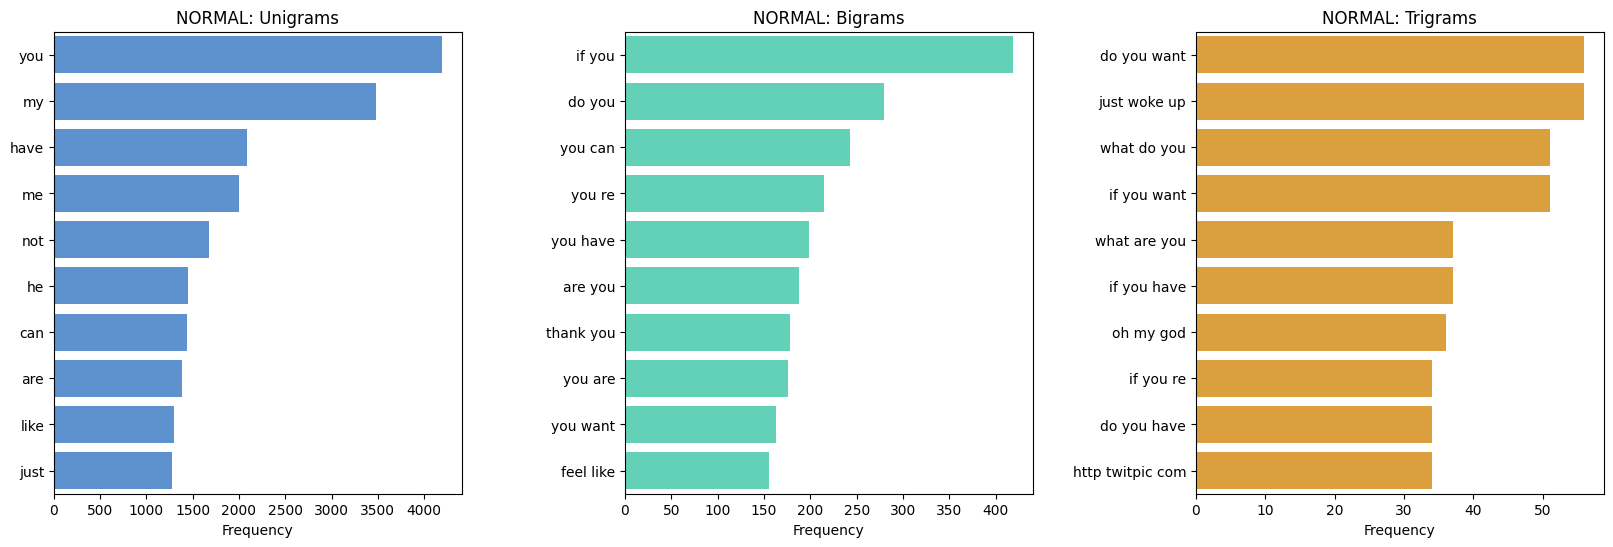

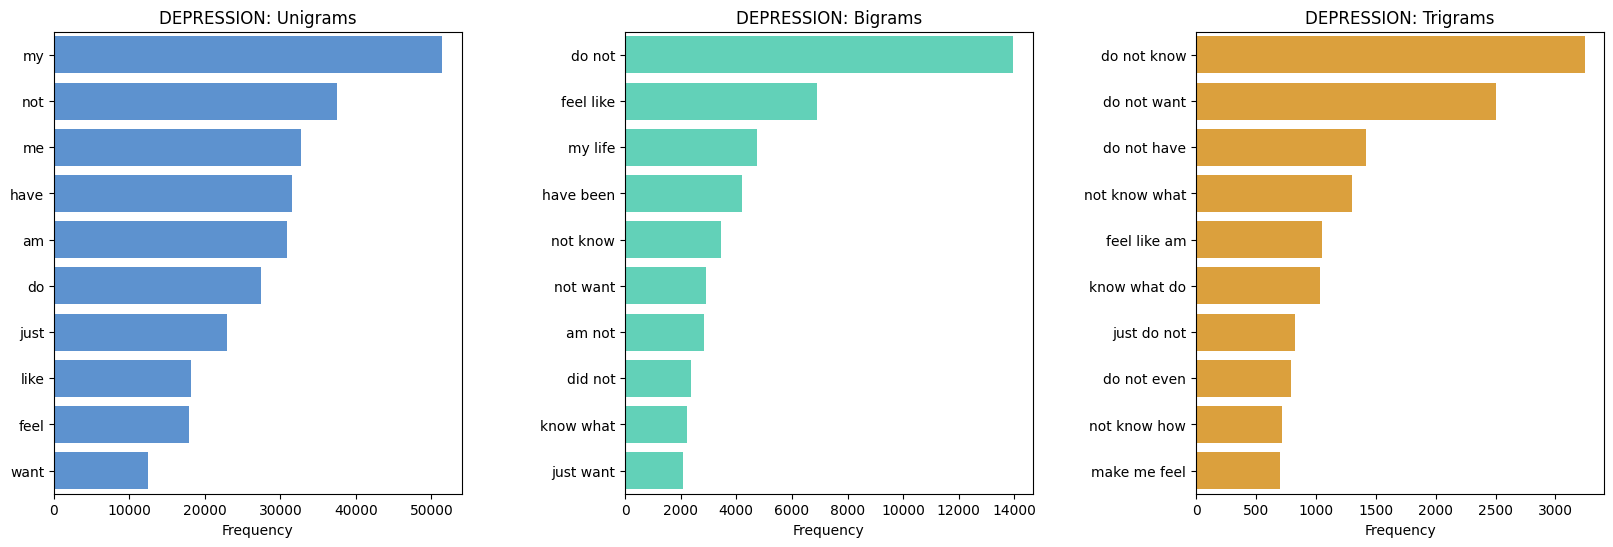

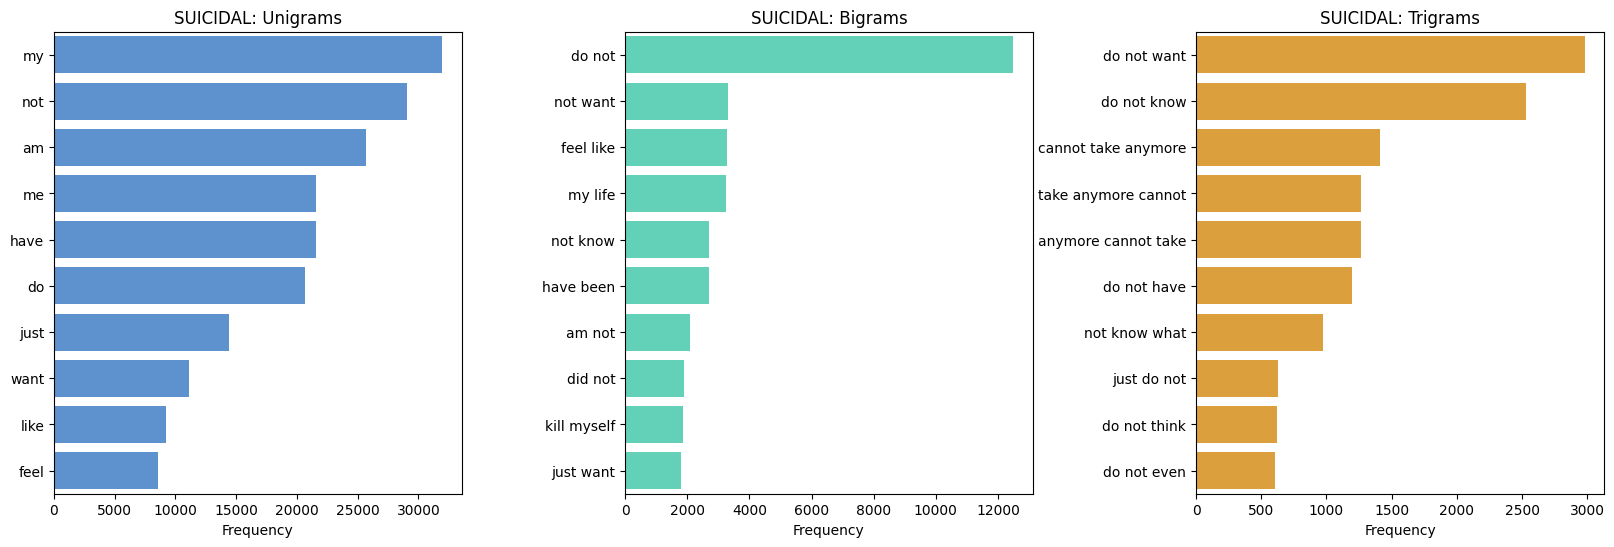

In [16]:
ngram_comparison(df, status_label="Normal")
ngram_comparison(df, status_label="Depression")
ngram_comparison(df, status_label="Suicidal")

# 4. Model Training and Hyperparameter Tuning

In [17]:
SEED = 42
MODEL_DIR = "models"
STUDY_DIR = "studies"
os.makedirs(MODEL_DIR, exist_ok=True)
os.makedirs(STUDY_DIR, exist_ok=True)

In [18]:
X = df["statement_processed"]
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

In [19]:
sampler = optuna.samplers.TPESampler(seed=SEED)

## 4.1. Softmax Regression (Multinomial Logistic Regression)

In [20]:
def lr_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    solver = trial.suggest_categorical("lr__solver", ["lbfgs", "saga"])
    C = trial.suggest_float("lr__C", 0.1, 10, log=True)

    penalty = "l2"
    if solver == "saga":
        penalty = trial.suggest_categorical("lr__penalty", ["l1", "l2"])

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "lr",
                LogisticRegression(
                    max_iter=5000,
                    solver=solver,
                    penalty=penalty,
                    C=C,
                    class_weight="balanced",
                    random_state=SEED,
                ),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )
    return score.mean()

In [ ]:
study_lr = optuna.create_study(direction="maximize", sampler=sampler)
study_lr.optimize(lr_objective, n_trials=30)

print(f"Best LR Score: {study_lr.best_value}")
print(f"Best LR Params :{study_lr.best_params}")

[I 2026-01-13 14:02:29,070] A new study created in memory with name: no-name-0d6e906c-b38e-4dbf-8f41-598b67344823
/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/data/CiCi/code/projects/uit/cs221/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
/data/CiCi/code/projects/uit/cs221/.ve

## 4.2. Linear Support Vector Classification (Linear SVC)

In [ ]:
def svc_objective(trial):
    max_features = trial.suggest_int("tfidf__max_features", 5000, 20000, step=500)
    max_df = trial.suggest_float("tfidf__max_df", 0.8, 0.95)
    min_df = trial.suggest_int("tfidf__min_df", 2, 7)

    C = trial.suggest_float("svc__C", 0.01, 10, log=True)

    penalty = trial.suggest_categorical("svc__penalty", ["l1", "l2"])

    if penalty == "l1":
        loss = "squared_hinge"
        dual = False
    else:
        loss = trial.suggest_categorical("svc__loss", ["hinge", "squared_hinge"])
        dual = False if loss == "squared_hinge" else True

    pipeline = Pipeline(
        [
            (
                "tfidf",
                TfidfVectorizer(
                    ngram_range=(1, 3),
                    token_pattern=r"\S+",
                    max_features=max_features,
                    max_df=max_df,
                    min_df=min_df,
                ),
            ),
            (
                "svc",
                LinearSVC(
                    C=C,
                    penalty=penalty,
                    loss=loss,
                    dual=dual,
                    class_weight="balanced",
                    max_iter=5000,
                    random_state=SEED,
                ),
            ),
        ]
    )

    score = cross_val_score(
        pipeline, X_train, y_train, cv=5, scoring="f1_macro", n_jobs=-1
    )
    return score.mean()

In [ ]:
study_svc = optuna.create_study(direction="maximize", sampler=sampler)
study_svc.optimize(svc_objective, n_trials=30)

print(f"Best SVC Score: {study_svc.best_value}")
print(f"Best SVC Params :{study_svc.best_params}")

In [ ]:
joblib.dump(study_lr, os.path.join(STUDY_DIR, "study_lr.pkl"))
joblib.dump(study_svc, os.path.join(STUDY_DIR, "study_svc.pkl"))

In [ ]:
lr_params = study_lr.best_params

lr_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=lr_params["tfidf__max_features"],
                max_df=lr_params["tfidf__max_df"],
                min_df=lr_params["tfidf__min_df"],
            ),
        ),
        (
            "lr",
            LogisticRegression(
                max_iter=5000,
                solver=lr_params["lr__solver"],
                penalty=lr_params.get("lr__penalty", "l2"),
                C=lr_params["lr__C"],
                class_weight="balanced",
                random_state=SEED,
            ),
        ),
    ]
)
lr_pipeline.fit(X_train, y_train)

In [ ]:
svc_params = study_svc.best_params

svc_penalty = svc_params["svc__penalty"]
if svc_penalty == "l1":
    svc_loss = "squared_hinge"
    svc_dual = False
else:
    svc_loss = svc_params["svc__loss"]
    svc_dual = False if svc_loss == "squared_hinge" else True

svc_pipeline = Pipeline(
    [
        (
            "tfidf",
            TfidfVectorizer(
                ngram_range=(1, 3),
                token_pattern=r"\S+",
                max_features=svc_params["tfidf__max_features"],
                max_df=svc_params["tfidf__max_df"],
                min_df=svc_params["tfidf__min_df"],
            ),
        ),
        (
            "svc",
            LinearSVC(
                C=svc_params["svc__C"],
                penalty=svc_penalty,
                loss=svc_loss,
                dual=svc_dual,
                class_weight="balanced",
                max_iter=5000,
                random_state=SEED,
            ),
        ),
    ]
)
svc_pipeline.fit(X_train, y_train)

In [ ]:
joblib.dump(lr_pipeline, os.path.join(MODEL_DIR, "lr_pipeline.pkl"))
joblib.dump(svc_pipeline, os.path.join(MODEL_DIR, "svc_pipeline.pkl"))

# 5. Model Evaluation and Comparison

In [ ]:
y_pred_lr = lr_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_lr))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_lr, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

In [ ]:
y_pred_svc = svc_pipeline.predict(X_test)

print(classification_report(y_test, y_pred_svc))

fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred_svc, cmap="Blues", ax=ax)

plt.title("Confusion Matrix")
plt.show()

## 6. Case Study

In [ ]:
def plot_local_importance(pipeline, text, actual_label, pred_label, sample_type):
    tfidf = pipeline.named_steps["tfidf"]
    svc = pipeline.named_steps["svc"]

    x_vec = tfidf.transform([text])
    class_labels = list(svc.classes_)
    pred_idx = class_labels.index(pred_label)

    x_dense = x_vec.toarray()[0]
    weights = svc.coef_[pred_idx]
    if hasattr(weights, "toarray"):
        weights = weights.toarray()[0]
    else:
        weights = weights.flatten()

    # 3. Calculate importance
    importance = x_dense * weights
    feature_names = tfidf.get_feature_names_out()
    indices = np.argsort(importance)[-5:]
    plot_indices = [i for i in indices if importance[i] > 0]

    if not plot_indices:
        print(f"No positive contributing features found for this {sample_type}.")
        return

    values = importance[plot_indices]
    names = feature_names[plot_indices]

    plt.figure(figsize=(5, 5))
    color = "#2ecc71" if "CORRECT" in sample_type else "#e74c3c"

    sns.barplot(x=values, y=names, color=color)
    plt.title(
        f"{sample_type}\nActual: {actual_label} | Predicted: {pred_label}", fontsize=12
    )
    plt.xlabel("Contribution Score (TF-IDF x SVC Coefficient)", fontsize=10)
    plt.ylabel("Key Words", fontsize=10)
    sns.despine()
    plt.tight_layout()
    plt.show()


def analyze_visual_random(pipeline, X_val, y_val):
    y_pred = pipeline.predict(X_val)
    results = pd.DataFrame({"text": X_val, "actual": y_val, "pred": y_pred})
    classes = sorted(results["actual"].unique())

    for cls in classes:
        print("\n" + "=" * 60)
        print(f" CLASS: {cls}")
        print("=" * 60)

        correct_pool = results[(results["actual"] == cls) & (results["pred"] == cls)]
        wrong_pool = results[(results["actual"] == cls) & (results["pred"] != cls)]

        samples = [
            ("CORRECT PREDICTION", correct_pool),
            ("WRONG PREDICTION", wrong_pool),
        ]

        for label, pool in samples:
            if pool.empty:
                continue

            # Select a random sample from the pool
            data = pool.sample(n=1).iloc[0]

            text_val = data["text"]
            actual_val = data["actual"]
            pred_val = data["pred"]

            print(f"\n[{label}] Random Text snippet: {text_val}...")
            plot_local_importance(pipeline, text_val, actual_val, pred_val, label)


analyze_visual_random(svc_pipeline, X_test, y_test)

In [ ]:
svc_pipeline = joblib.load("./svc_pipeline.pkl")

In [ ]:
def plot_linear_svc_importance(pipeline, target_class, top_n=10):
    tfidf = pipeline.named_steps["tfidf"]
    svc = pipeline.named_steps["svc"]

    feature_names = tfidf.get_feature_names_out()
    classes = list(svc.classes_)
    target_idx = classes.index(target_class)

    # LinearSVC coef_ is (n_classes, n_features) for multi-class
    # For binary, it's (1, n_features)
    if svc.coef_.shape[0] == 1:
        weights = svc.coef_[0] if target_idx == 1 else -svc.coef_[0]
    else:
        weights = svc.coef_[target_idx]

    # Get indices of the top N weights
    indices = np.argsort(weights)[-top_n:]

    # Validation: Filter out weights that are effectively zero or negative
    # This prevents 'leaked' features from other classes showing up
    plot_indices = [i for i in indices if weights[i] > 0]

    if not plot_indices:
        print(f"No positive features found for {target_class}")
        return

    plt.figure(figsize=(8, 5))
    sns.barplot(x=weights[plot_indices], y=feature_names[plot_indices], palette="magma")
    plt.title(f"Top Discriminative Features: {target_class}", fontsize=12)
    plt.xlabel("Weight Strength")
    sns.despine()
    plt.show()


# Loop through all available classes (Normal, Depression, Suicidal, etc.)
for cls in svc_pipeline.named_steps["svc"].classes_:
    print(f"Analyzing Importance for: {cls}")
    plot_linear_svc_importance(svc_pipeline, cls)